In [1]:
import numpy as np 
import pandas as pd
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

#for interactive visualizations
import plotly.offline as py
import plotly.graph_objs as go
from scipy.stats import pearsonr
import plotly.figure_factory as ff
from itertools import product
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)
from plotly import tools

In [2]:
import pandas as pd

In [3]:
### Loading the Datasets
mall_data = pd.read_csv("mall.csv")

In [4]:
mall_data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
mall_data.isnull().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [6]:
mall_data[mall_data.duplicated()]

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)


In [7]:
mall_data.shape

(200, 5)

In [8]:
mall_data.nunique()

CustomerID                200
Genre                       2
Age                        51
Annual Income (k$)         64
Spending Score (1-100)     84
dtype: int64

In [9]:
mall_data.rename(columns = {'Genre':'Gender'}, inplace = True)

In [10]:
mall_data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [11]:
#Seprating out the categorical and continuous variables
def seperate_data_types(data):
    categorical=[]
    continuous=[]
    for column in data.columns:
        if data[column].nunique () < 100:
            categorical.append(column)
        else:
            continuous.append(column)
    return categorical, continuous

categorical, continuous=seperate_data_types(mall_data)

from tabulate import tabulate

Lable=[categorical, continuous]

print(tabulate({"Categorical":categorical,"continuous": continuous}, headers = ["categorical", "continuous"]))

categorical             continuous
----------------------  ------------
Gender                  CustomerID
Age
Annual Income (k$)
Spending Score (1-100)


In [12]:
categorical.remove("Age")
continuous.append("Age")

categorical.remove("Annual Income (k$)")
continuous.append("Annual Income (k$)")

categorical.remove("Spending Score (1-100)")
continuous.append("Spending Score (1-100)")

In [13]:
print("row and column before removing outliers:",mall_data.shape)

def myoutliers(data,col):
    Q3=np.quantile(data[col],0.75)
    Q1=np.quantile(data[col],0.25)
    
    IQR=Q3-Q1
    
    global mylist
    global my_outlier_df
    
    lower_range=Q1-1.5*IQR
    upper_range=Q3+1.5*IQR
    
    print('the lower range of',col,"is",lower_range)
    print("the upper range of ",col,"is",upper_range)
    
    mylist=[x for x in data[col] if ((x<lower_range)|(x>upper_range))]
    print("total outliers in",col,"are",len(mylist))
    my_outlier_df=data.loc[data[col].isin(mylist)]
    
k=['Age','Annual Income (k$)','Spending Score (1-100)']       


for i in k:
    print("i is ",i)
    myoutliers(mall_data,i)
    print("***************")

row and column before removing outliers: (200, 5)
i is  Age
the lower range of Age is -1.625
the upper range of  Age is 79.375
total outliers in Age are 0
***************
i is  Annual Income (k$)
the lower range of Annual Income (k$) is -13.25
the upper range of  Annual Income (k$) is 132.75
total outliers in Annual Income (k$) are 2
***************
i is  Spending Score (1-100)
the lower range of Spending Score (1-100) is -22.625
the upper range of  Spending Score (1-100) is 130.375
total outliers in Spending Score (1-100) are 0
***************


There is no outlier in Age and Spending Score but in Annual Income we are getting 2 outlier but i'm not considering them as a outlier because annual income can also be high.

### EDA

#### Data Visualization



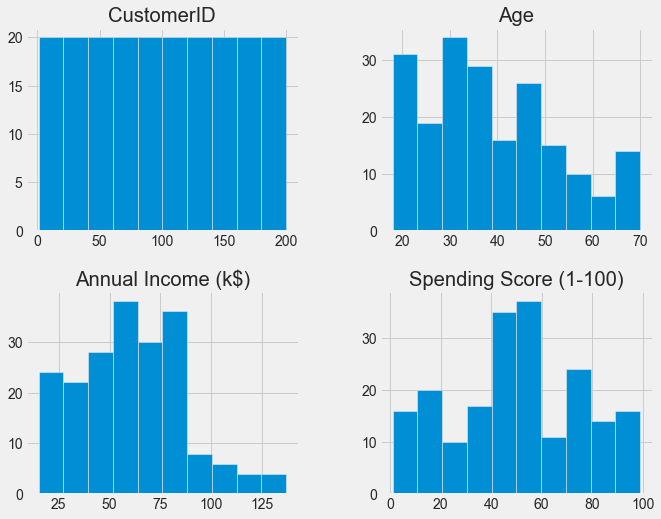

In [14]:
### hist plot
mall_data.hist(figsize = (10, 8))
plt.show()

### In Age columns most people belong to 18 to 50 Age,
### Maximum Annual Income 45k to 90k.
### Maximum Spending Sore is 50

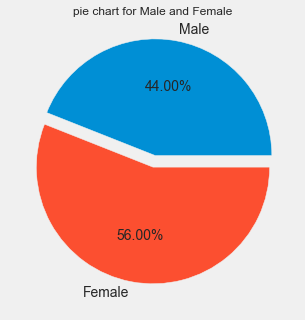

In [15]:
labels = 'Male', 'Female'
sizes = [mall_data.Gender[mall_data['Gender']=='Male'].count(), mall_data.Gender[mall_data['Gender']=='Female'].count()]
explode = (0.1,0.001)
fig1, ax1 = plt.subplots(figsize=(8, 5))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%')
plt.title("pie chart for Male and Female", size = 12)
plt.show()

In [16]:
mall_data

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


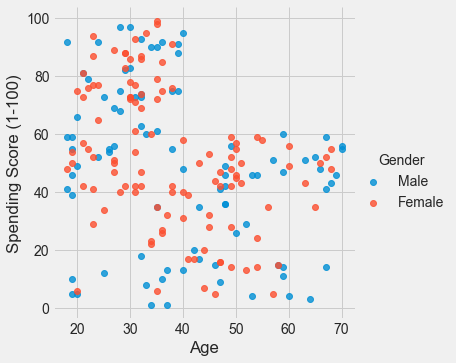

In [17]:
sns.lmplot(x='Age',y='Spending Score (1-100)', data=mall_data, hue="Gender", fit_reg=False);

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



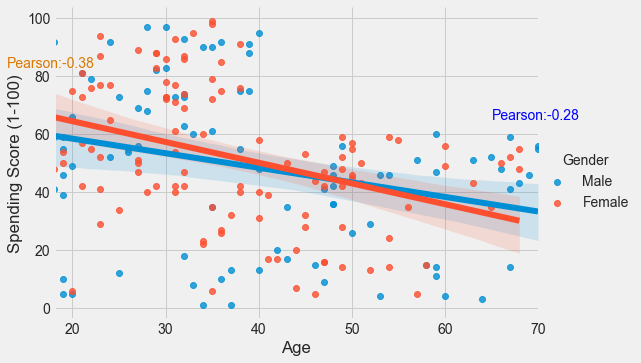

In [18]:
males_age=mall_data[mall_data['Gender']=='Male']['Age']
females_age=mall_data[mall_data['Gender']=='Female']['Age']

males_spending=mall_data[mall_data['Gender']=='Male']['Spending Score (1-100)']
females_spending=mall_data[mall_data['Gender']=='Female']['Spending Score (1-100)']

corr1,_=pearsonr(males_age.values,males_spending.values)
corr2,_=pearsonr(females_age.values,females_spending.values)

sns.lmplot('Age','Spending Score (1-100)',data=mall_data,hue="Gender",aspect=1.5)
plt.text(65,65,'Pearson:{:.2f}'.format(corr1),color='blue')
plt.text(13,83,'Pearson:{:.2f}'.format(corr2),color='#d97900')
plt.show()

there is a -ve co-relation b/w age and spendinding age which means increase in age less in spending
age group of (20-40) spending more as compared to age group (50-70)

#### checking correlation 

In [19]:
corr_table=mall_data.corr()
corr_table

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,1.000000,-0.026763,0.977548,0.013835
Age,-0.026763,1.000000,-0.012398,-0.327227
Annual Income (k$),0.977548,-0.012398,1.000000,0.009903
Spending Score (1-100),0.013835,-0.327227,0.009903,1.000000


In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

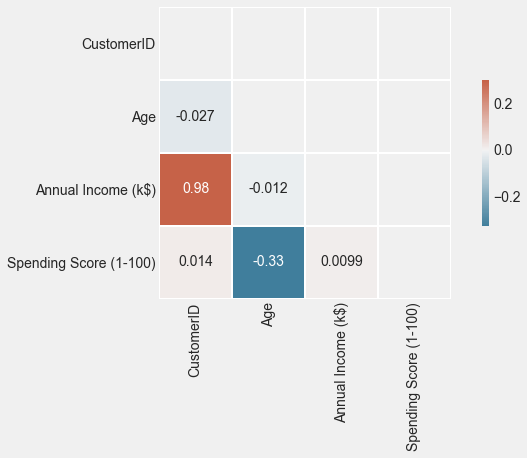

In [21]:
corr = mall_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

In [22]:
from sklearn.cluster import KMeans


In [23]:
#Considering only 2 features (Annual income and Spending Score) and no Label available
X= mall_data.iloc[:, [3,4]].values

In [24]:
mall_data1=mall_data.drop(["CustomerID","Gender"],axis=1)

In [25]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

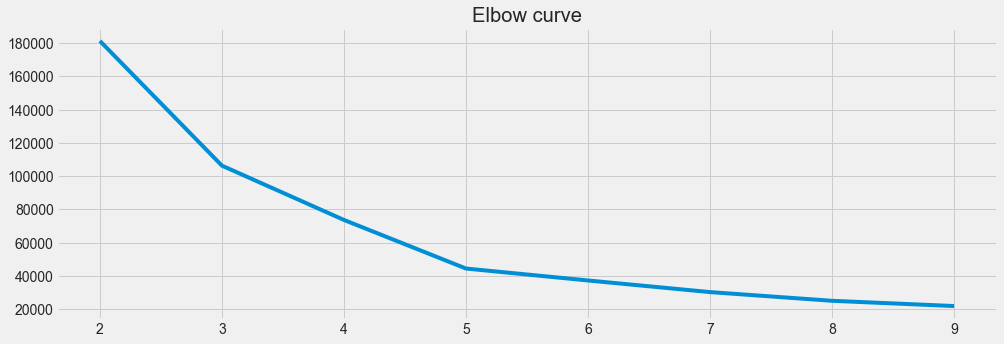

In [26]:
distorsions = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve');

### from the above graph we got  have 2 sharp edges i.e. k=3 and k=5 but in k=3 we can see siginificant diffrence in values so we will go with k=5

For n_clusters = 2 The average silhouette_score is : 0.2968969162503008
For n_clusters = 3 The average silhouette_score is : 0.46761358158775435
For n_clusters = 4 The average silhouette_score is : 0.4931963109249047
For n_clusters = 5 The average silhouette_score is : 0.553931997444648
For n_clusters = 6 The average silhouette_score is : 0.5376203956398481


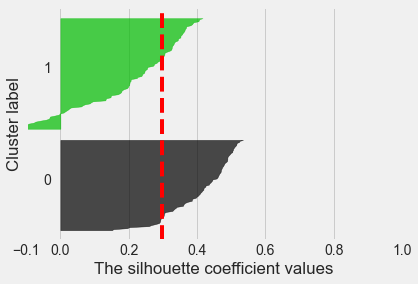

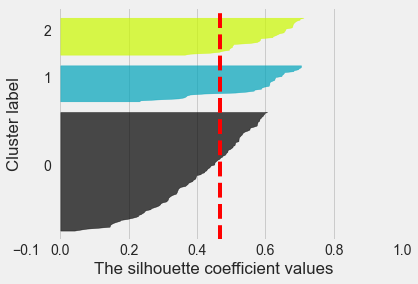

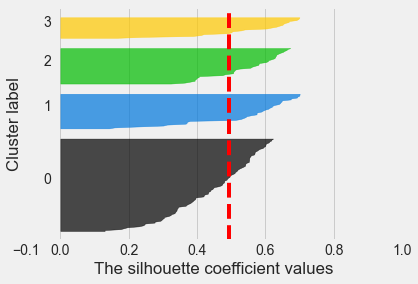

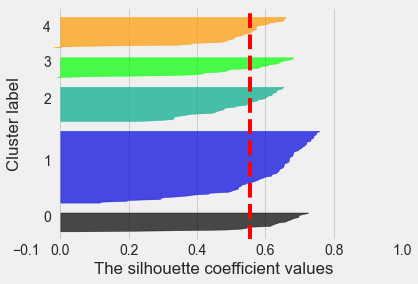

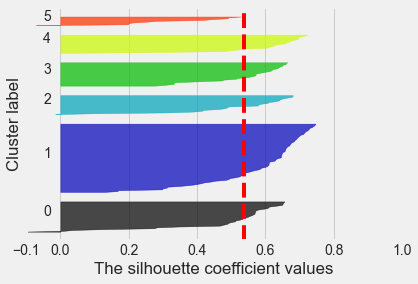

In [27]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

In [ ]:
#################

## K-Means

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



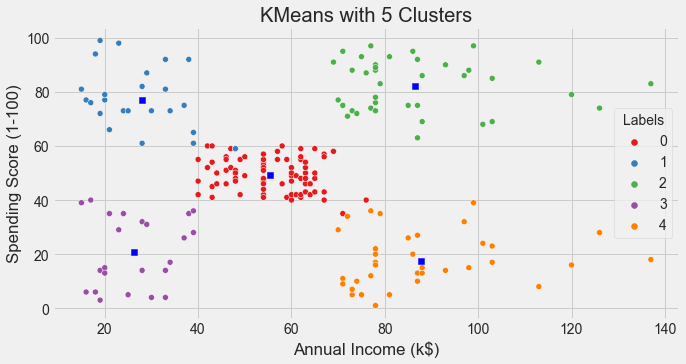

............


In [98]:
km5 = KMeans(n_clusters=5).fit(mall_data1)
centroids = km5.cluster_centers_
#print(centroids)
mall_data1['Labels'] = km5.labels_
plt.figure(figsize=(10, 5))
scat1=sns.scatterplot(mall_data1['Annual Income (k$)'],mall_data1['Spending Score (1-100)'],  hue=mall_data1['Labels'], 
                palette="Set1",legend="full")
scat1.scatter(km5.cluster_centers_[:,1],km5.cluster_centers_[:,2],marker="s",s=40,c="blue")
plt.title('KMeans with 5 Clusters')
plt.show()
print("............")

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



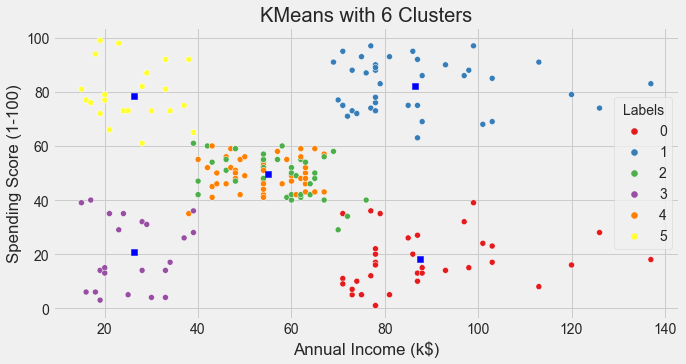

In [31]:

km6 = KMeans(n_clusters=6).fit(mall_data)
centroids = km6.cluster_centers_
#print(centroids)
mall_data['Labels'] = km6.labels_
plt.figure(figsize=(10, 5))
scat1=sns.scatterplot(mall_data['Annual Income (k$)'],mall_data['Spending Score (1-100)'],  hue=mall_data['Labels'], 
                palette="Set1",legend="full")
scat1.scatter(km5.cluster_centers_[:,1],km5.cluster_centers_[:,2],marker="s",s=40,c="blue")
plt.title('KMeans with 6 Clusters')
plt.show()

In [32]:
KM5_clustered=mall_data.copy()
KM5_clustered.loc[:,'Cluster']=km5.labels_ #append labels to points

In [33]:
KM5_clust_sizes=KM5_clustered.groupby("Cluster").size().to_frame()
KM5_clust_sizes.columns=["KM5_size"]
KM5_clust_sizes

,KM5_size
Cluster,
0,39
1,78
2,23
3,37
4,23


## DBSCAN

In [34]:
#Define required method to plot the data
from sklearn.cluster import DBSCAN

df  = mall_data
#print(df)


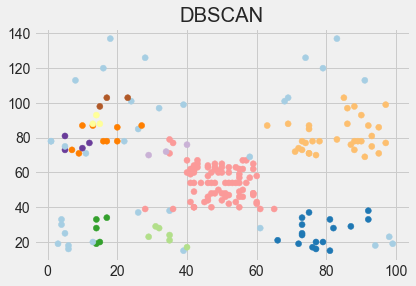

min_samples 3 eps 10.0


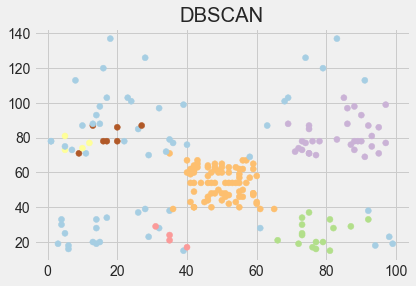

min_samples 4 eps 10.0


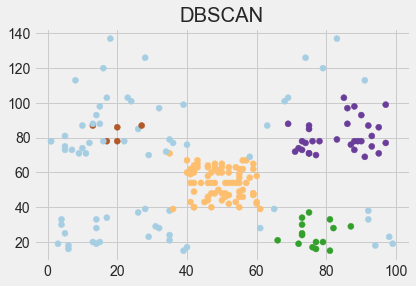

min_samples 5 eps 10.0


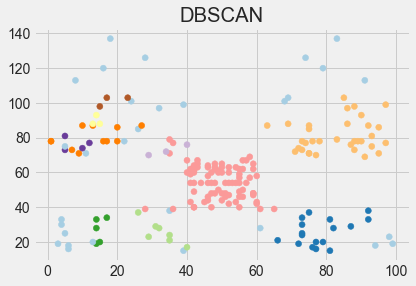

min_samples 3 eps 10.5


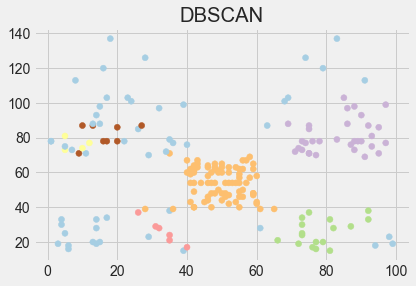

min_samples 4 eps 10.5


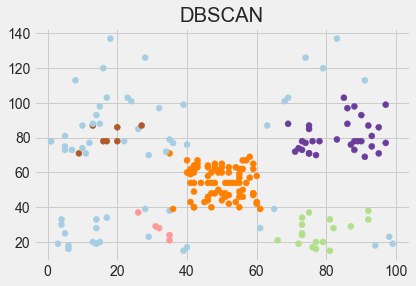

min_samples 5 eps 10.5


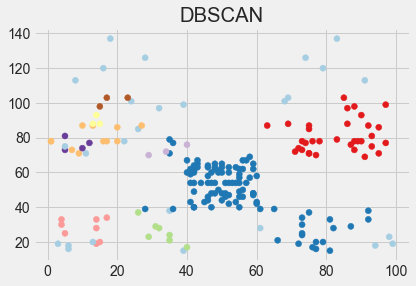

min_samples 3 eps 11.0


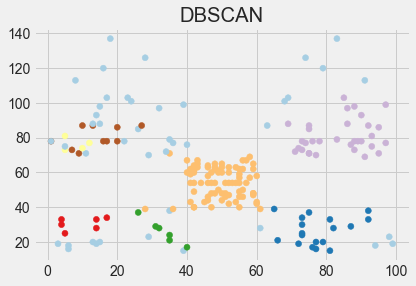

min_samples 4 eps 11.0


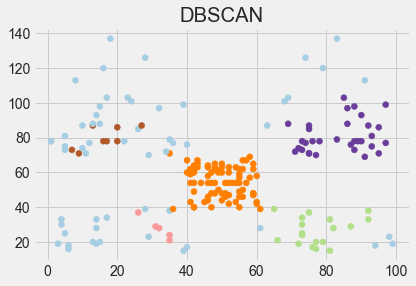

min_samples 5 eps 11.0


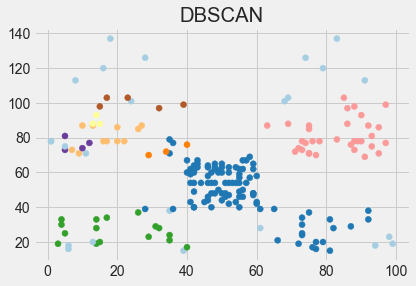

min_samples 3 eps 11.5


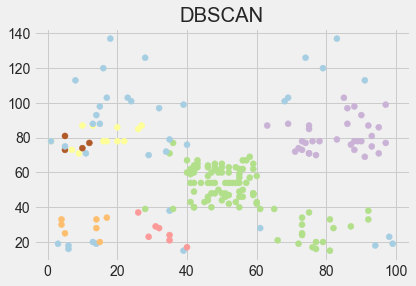

min_samples 4 eps 11.5


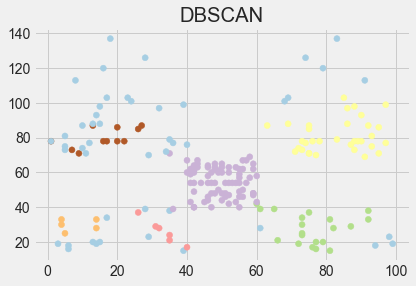

min_samples 5 eps 11.5


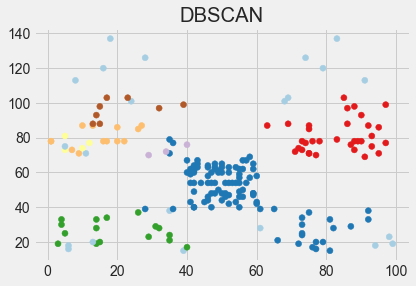

min_samples 3 eps 12.0


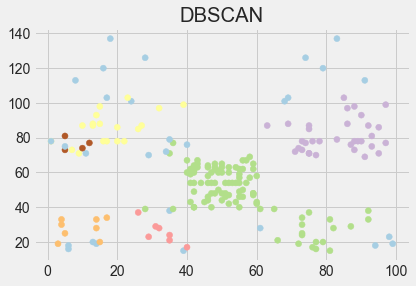

min_samples 4 eps 12.0


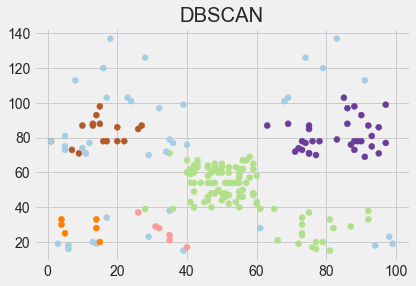

min_samples 5 eps 12.0


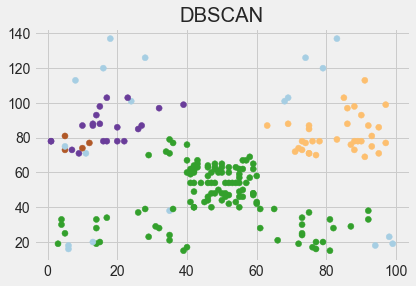

min_samples 3 eps 12.5


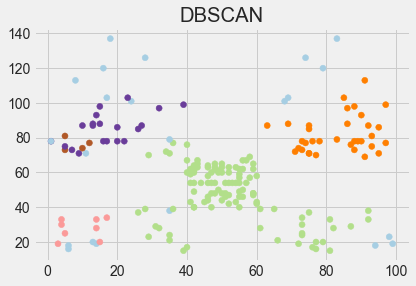

min_samples 4 eps 12.5


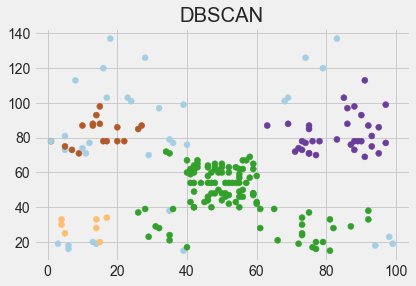

min_samples 5 eps 12.5


In [35]:
eps=np.arange(10,12.75,0.5)
min_samples= [3,4,5]
for y in eps:
    for x in min_samples:
        dbscan = DBSCAN(eps=y, min_samples=x)
        df['clusterid'] = dbscan.fit_predict(df)
        y_pred=df['clusterid']
        plt.scatter(df['Spending Score (1-100)'],df['Annual Income (k$)'],c=y_pred, cmap='Paired')
        plt.title("DBSCAN")
        plt.show()
        print('min_samples',x,'eps',y)
        #DBSCAN_params=list(product(eps,min_samples))

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



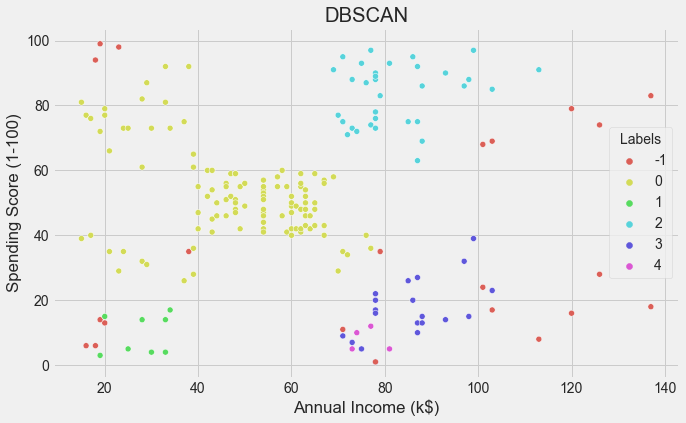

In [36]:
db=DBSCAN(eps=12.5, min_samples=4).fit(mall_data)

mall_data['Labels'] = db.labels_
plt.figure(figsize=(10, 6)) 
sns.scatterplot(mall_data['Annual Income (k$)'],mall_data['Spending Score (1-100)'], hue=mall_data['Labels'], 
                 palette=sns.color_palette('hls', np.unique(db.labels_).shape[0]))

plt.title('DBSCAN')
plt.show()

The graph above there are some outliers -these points do not meet distance and minimum sample requirements to be recongnised as a cluster

In [37]:
DB_clustered=mall_data.copy()
DB_clustered.loc[:,'Cluster']=db.labels_ #append labels to points

In [38]:
DB_clust_sizes=DB_clustered.groupby("Cluster").size().to_frame()
DB_clust_sizes.columns=["DB_size"]
DB_clust_sizes #observation

,DB_size
Cluster,
-1,22
0,112
1,8
2,34
3,20
4,4


## Agglomerative Clustering

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



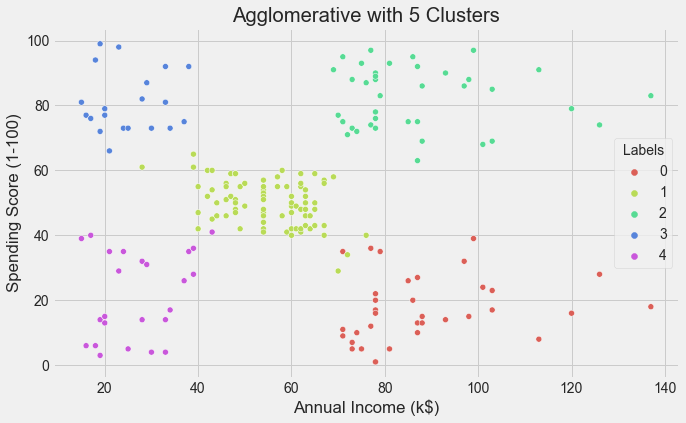

In [39]:
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
agglom = AgglomerativeClustering(n_clusters=5, linkage='average').fit(mall_data)

mall_data['Labels']= agglom.labels_

plt.figure(figsize=(10, 6))

sns.scatterplot(mall_data['Annual Income (k$)'],mall_data['Spending Score (1-100)'], hue=mall_data['Labels'],
                palette=sns.color_palette( 'hls', np.unique(agglom.labels_).shape[0]))

plt.title('Agglomerative with 5 Clusters') 
plt.show()

In [40]:
from scipy.cluster import hierarchy
from scipy.spatial import distance_matrix

In [41]:
dist=distance_matrix(mall_data,mall_data)

<ipython-input-42-6381b6dd434d>:1: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



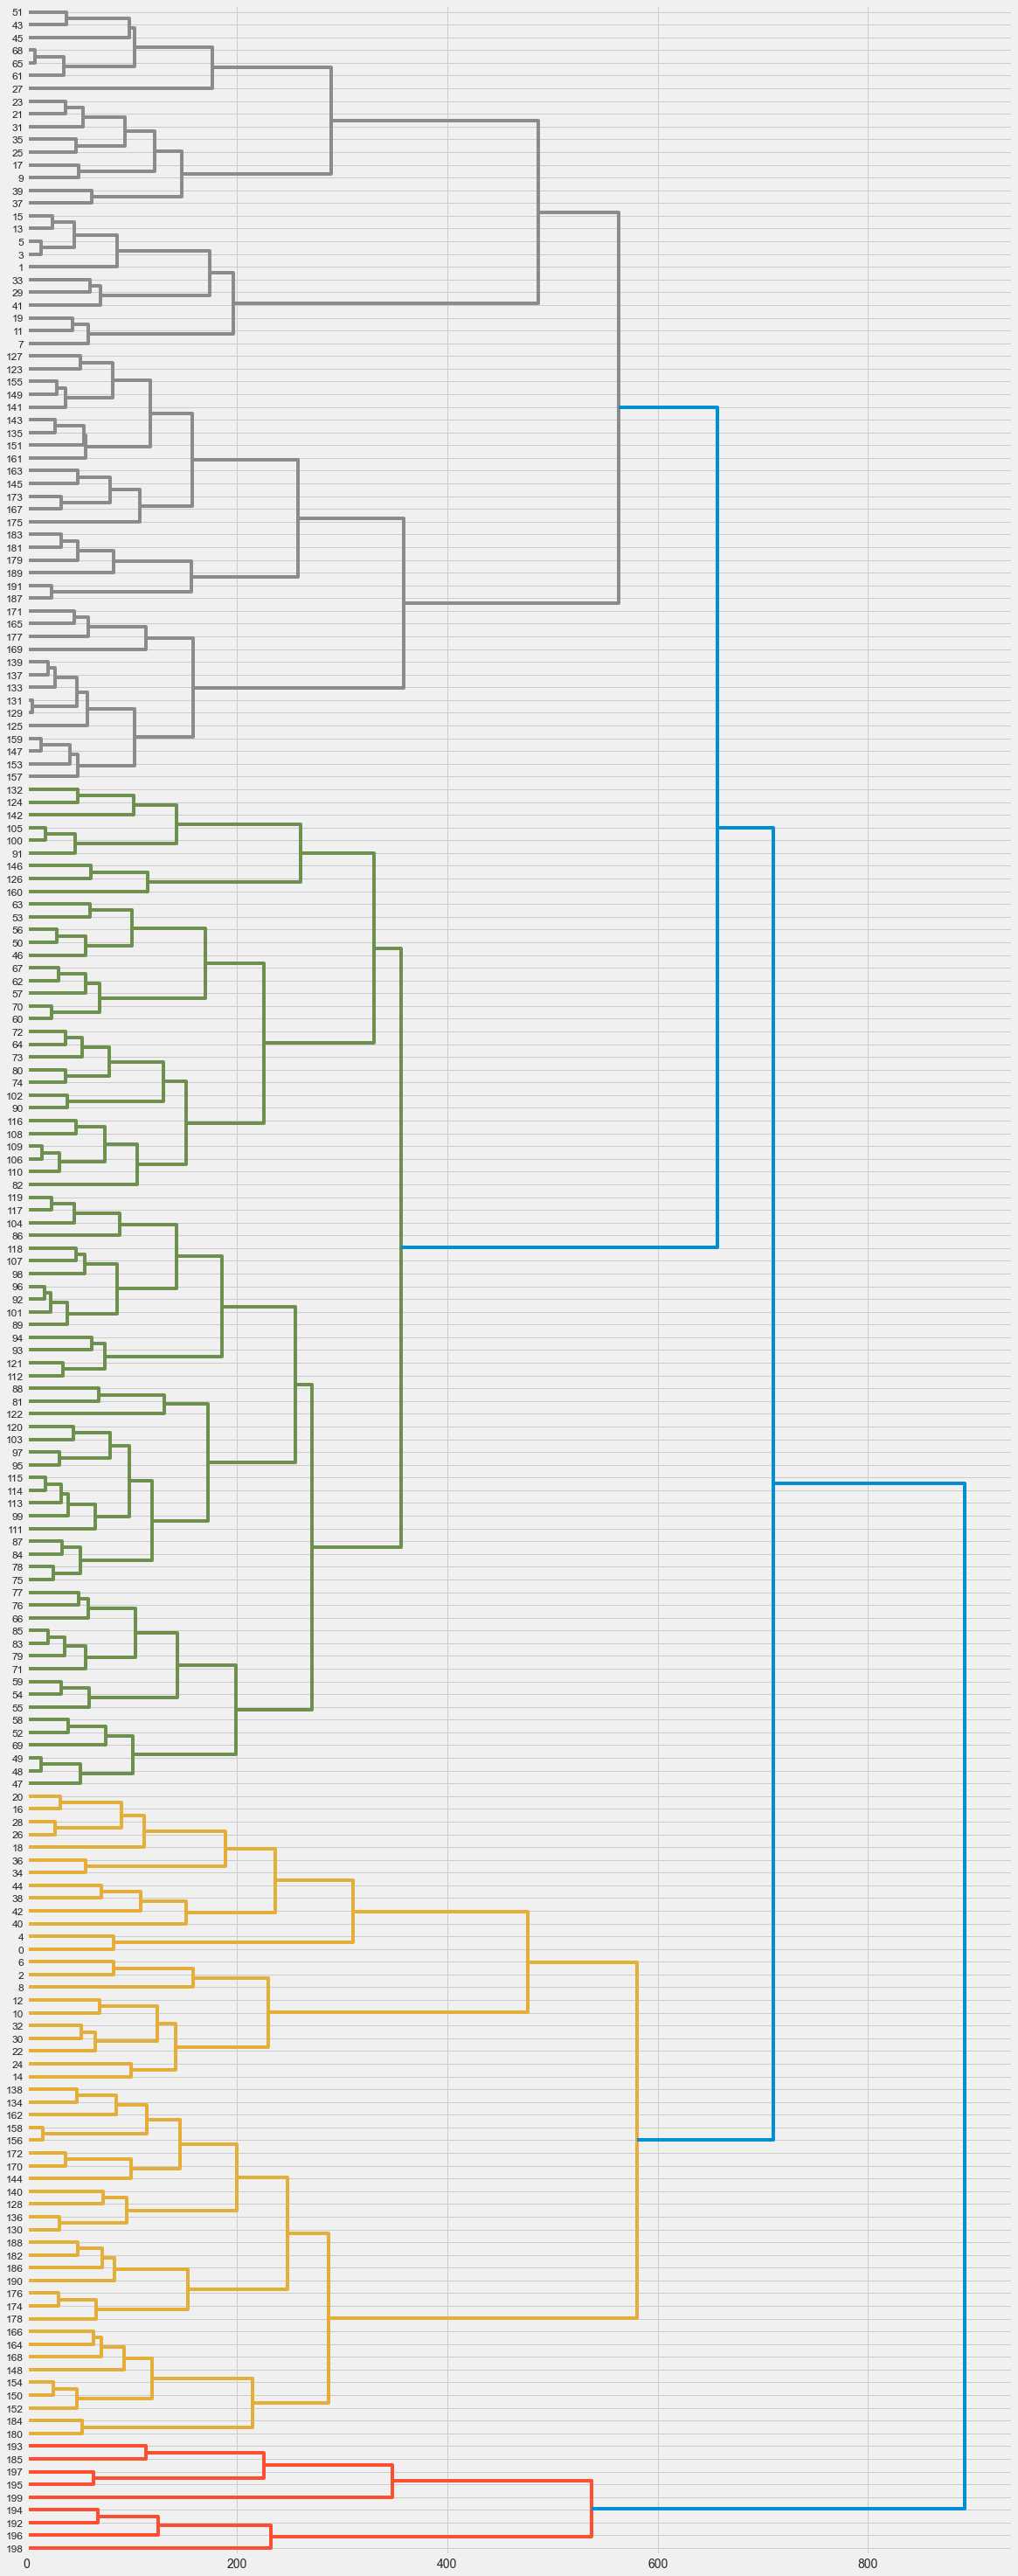

In [42]:
Z=hierarchy.linkage(dist,'complete')
plt.figure(figsize=(18,50))
dendro=hierarchy.dendrogram(Z,leaf_rotation=0,leaf_font_size=12,orientation='right')

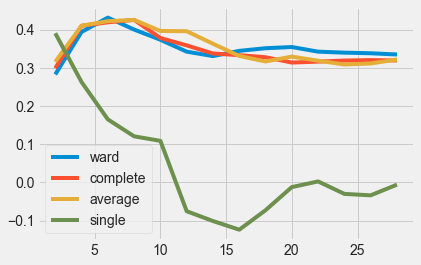

In [43]:
range_n_clusters = np.arange(2,30,2)

linkage = ['ward', 'complete', 'average', 'single']

res=[[],[],[],[]] 

for lin in range(len(linkage)):

    for n_clusters in range_n_clusters:

        clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage = linkage[lin])

        cluster_labels = clusterer.fit_predict(df)

        silhouette_avg = silhouette_score(df, cluster_labels)

        res[lin].append(silhouette_avg)

for i in range(len(res)):

    plt.plot(range_n_clusters, res[i], label=linkage[i])
plt.legend()
plt.show()

In [44]:
Agg_clustered=mall_data.copy()
Agg_clustered.loc[:,'Cluster']=agglom.labels_ #append labels to points

In [45]:
Agg_clust_sizes=Agg_clustered.groupby("Cluster").size().to_frame()
Agg_clust_sizes.columns=["Agg_size"]
Agg_clust_sizes

,Agg_size
Cluster,
0,35
1,82
2,39
3,20
4,24


# HDBSCAN

### Apply clustering


In [46]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(X)

HDBSCAN(gen_min_span_tree=True)

### Minimum Spanning Tree
### Let us have a look at the minium spanning tree that is computed based on the mutual reachbility.

<AxesSubplot:>

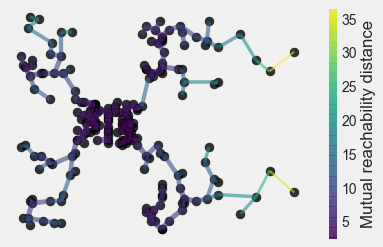

In [47]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

### Cluster Hierarchy
### Now, we will look at the hierachy that can be derived from the spanning tree.

<AxesSubplot:ylabel='distance'>

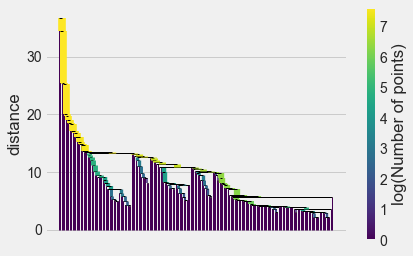

In [48]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

### Condense Hierarchy

<AxesSubplot:ylabel='$\\lambda$ value'>

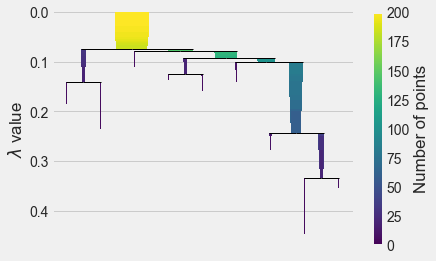

In [49]:
clusterer.condensed_tree_.plot()

### Get Clusters from Hierarchy

<AxesSubplot:ylabel='$\\lambda$ value'>

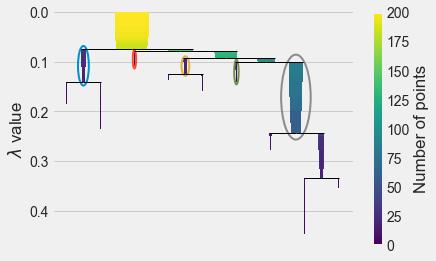

In [50]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

### Plot Final Clusters

In [51]:
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}


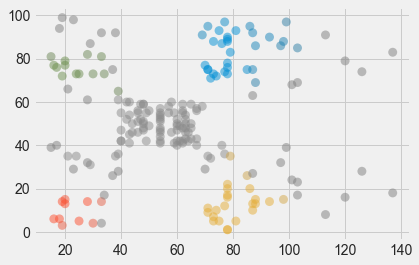

In [52]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(X.T[0], X.T[1], c=cluster_colors, **plot_kwds)

In [53]:
HDBSCAN_clustered=mall_data.copy()
HDBSCAN_clustered.loc[:,'Cluster']=clusterer.labels_ #append labels to points

In [54]:
HDBSCAN_clust_sizes=HDBSCAN_clustered.groupby("Cluster").size().to_frame()
HDBSCAN_clust_sizes.columns=["HDBSCAN_size"]
HDBSCAN_clust_sizes

,HDBSCAN_size
Cluster,
-1,35
0,32
1,10
2,23
3,13
4,87


In [55]:
clusters=pd.concat([KM5_clust_sizes,DB_clust_sizes,HDBSCAN_clust_sizes,Agg_clust_sizes],axis=1,sort=False)

In [56]:
clusters

,KM5_size,DB_size,HDBSCAN_size,Agg_size
Cluster,,,,
-1,NaN,22,35,NaN
0,39.0,112,32,35.0
1,78.0,8,10,82.0
2,23.0,34,23,39.0
3,37.0,20,13,20.0
4,23.0,4,87,24.0


Cluster No: 3
[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45]
observation in clusters 23
----------------------------------------------------------------------------------------------------
Cluster No: 1
[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 66
 69]
observation in clusters 25
----------------------------------------------------------------------------------------------------
Cluster No: 0
[ 47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64
  65  67  68  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 127 143]
observation in clusters 77
----------------------------------------------------------------------------------------------------
Cluster No: 2
[124 126 128 130 132 134 136 138 140 142 144 146 148 150 152 154 156 158
 160 162 164 166 168 170

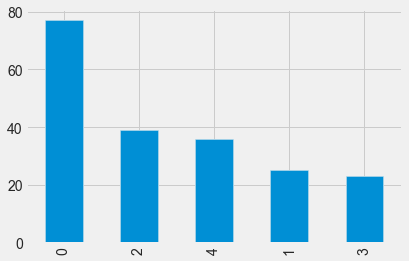

In [112]:
mall_data['cluster']= km5.labels_
for cluster in mall_data['cluster'].unique():
    print('Cluster No:', str(cluster))
    temp_df=mall_data[['CustomerID']][mall_data['cluster']== cluster]
    
    print(temp_df.CustomerID.unique())
    a=temp_df.CustomerID.unique()
    print("observation in clusters",a.size)
    mall_data.cluster.value_counts().plot(kind='bar')
    print(20*'-----')

Cluster No: 3
[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 43 45]
observation in clusters 22
----------------------------------------------------------------------------------------------------
Cluster No: 5
[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 46]
observation in clusters 22
----------------------------------------------------------------------------------------------------
Cluster No: 4
[ 41  47  51  54  55  56  57  58  60  61  63  64  65  67  68  71  72  73
  74  75  77  80  81  83  84  86  87  90  91  93  97  99 102 103 105 107
 108 109 110 111 117 118 119 120]
observation in clusters 44
----------------------------------------------------------------------------------------------------
Cluster No: 2
[ 44  48  49  50  52  53  59  62  66  69  70  76  78  79  82  85  88  89
  92  94  95  96  98 100 101 104 106 112 113 114 115 116 121 122 123 125
 133 143]
observation in clusters 38
-------------------------------------------------------------

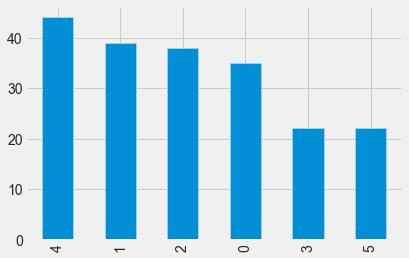

In [114]:
mall_data['cluster']= km6.labels_
for cluster in mall_data['cluster'].unique():
    print('Cluster No:', str(cluster))
    temp_df=mall_data[['CustomerID']][mall_data['cluster']== cluster]
    
    print(temp_df.CustomerID.unique())
    a=temp_df.CustomerID.unique()
    print("observation in clusters",a.size)
    mall_data.cluster.value_counts().plot(kind='bar')
    print(20*'-----')